In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense


In [2]:
epochs_number, batch_size_number, data_size = 1, 1, 5000

df = pd.read_csv('..\Data\AAPL_stock_prices.csv', delimiter=',')
df = df.iloc[-data_size:, :]
dates = pd.to_datetime(df['Date'])
df.drop(columns=['Date'], inplace=True)
df.index = dates

target_column_index = df.columns.tolist().index('Close')
print(target_column_index)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)
print(scaled_data[-2:, :])
print(df.head())

3
[[0.96668134 0.96458649 0.96391302 0.97034086 0.97291506 0.01526163]
 [0.97407419 0.97674263 0.97719752 0.97934994 0.98194417 0.00775856]]
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2004-07-23  0.563036  0.566964  0.544286  0.548214   0.463489  273571200
2004-07-26  0.550893  0.561607  0.549643  0.558214   0.471944  393932000
2004-07-27  0.567857  0.584821  0.563750  0.579107   0.489608  425006400
2004-07-28  0.576964  0.578750  0.556429  0.576250   0.487192  285051200
2004-07-29  0.579821  0.586071  0.573750  0.582857   0.492778  222157600


In [3]:
# def create_dataset(data: np.ndarray, time_step: int=10):
#     feature_number = data.shape[1]
#     Y = []
#     X = np.full((len(range(time_step, len(data) - 1)), time_step, feature_number), np.nan, dtype=float)
#     print(X.shape)
#     for i in range(time_step, len(data) - 1):
#         window = data[i - time_step : i, 0]

#         X[i - time_step, :, 0] = window.flatten()

#         Y.append(data[i, 0])
        
#     return X, np.array(Y, dtype=float).reshape(-1, 1), feature_number, time_step

def create_dataset(data: np.ndarray, time_step: int=10):
    X, Y = [], []
    for i in range(len(data) - time_step):
        # Define the range of input sequences
        end_ix = i + time_step
        
        # Define the range of output sequences
        out_end_ix = end_ix + 1
        
        # Ensure that the dataset is within bounds
        if out_end_ix > len(data)-1:
            break
            
        # Extract input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix], data[out_end_ix]
        
        # Append the parts
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y), data.shape[1], time_step


X, Y, feature_number, time_step = create_dataset(data=scaled_data)

print(type(X), type(Y), feature_number, time_step, sep=' ')
print(X.shape, Y.shape)
print(f"X:\n{X[:1, :]=}\nY:\n{Y[:1]=}")

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 6 10
(4989, 10, 6) (4989, 6)
X:
X[:1, :]=array([[[1.51908915e-04, 1.16608501e-04, 7.08964969e-05, 8.31467873e-05,
         7.04525724e-05, 7.45084395e-02],
        [9.04212328e-05, 8.96993768e-05, 9.81626301e-05, 1.33759607e-04,
         1.13339120e-04, 1.10448609e-01],
        [1.76320665e-04, 2.06307878e-04, 1.69965318e-04, 2.39504958e-04,
         2.02940228e-04, 1.19727537e-01],
        [2.22435068e-04, 1.75812168e-04, 1.32702564e-04, 2.25045014e-04,
         1.90687318e-04, 7.79364090e-02],
        [2.36901692e-04, 2.12587023e-04, 2.20863718e-04, 2.58484916e-04,
         2.19022513e-04, 5.91561528e-02],
        [2.53181323e-04, 2.28736689e-04, 2.09050164e-04, 2.31371466e-04,
         1.96047626e-04, 6.53866963e-02],
        [1.20261136e-04, 1.56975032e-04, 1.29974282e-04, 1.62684924e-04,
         1.37848266e-04, 1.01836881e-01],
        [1.44672886e-04, 1.13921331e-04, 1.31791215e-04, 1.36472279e-04,
         1.15637863e-04, 5.601245

(4989, 10, 6)


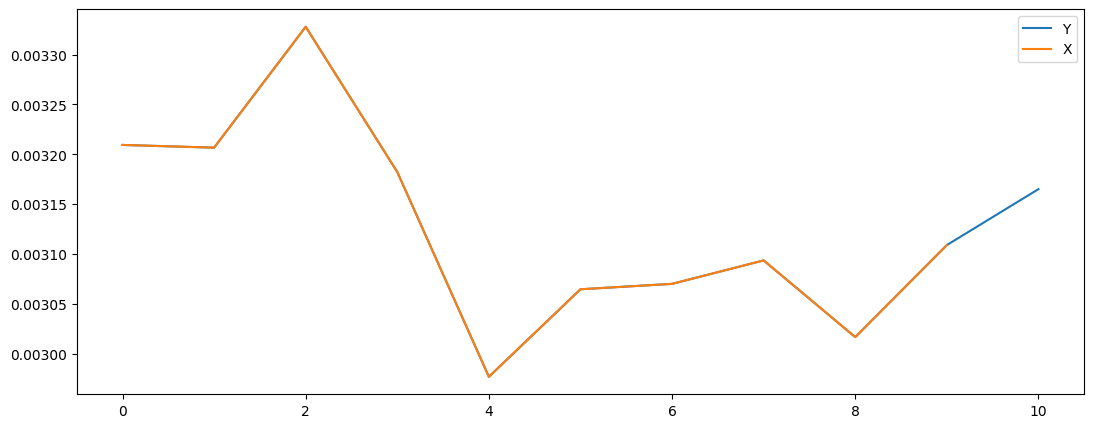

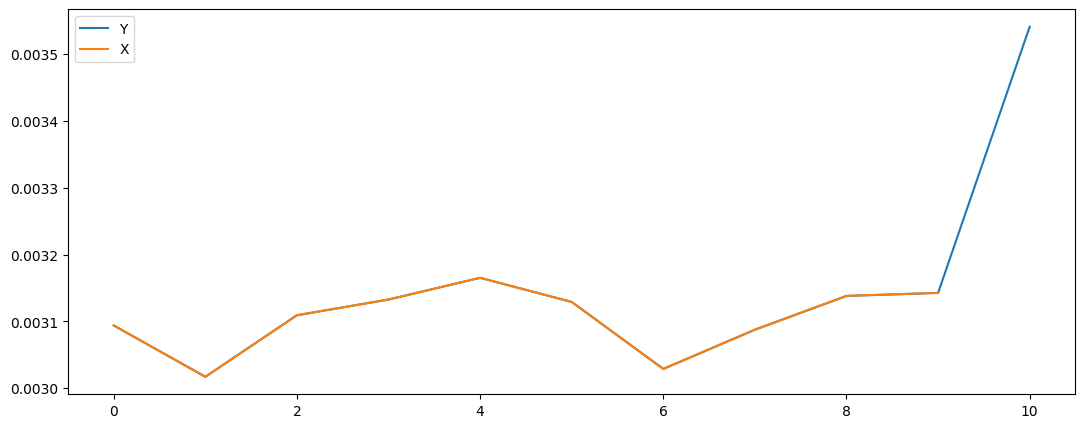

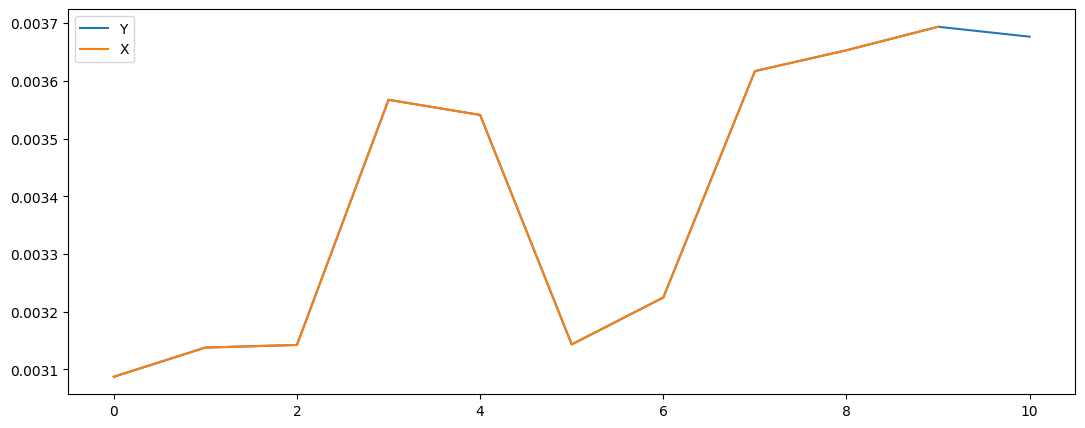

In [4]:
# Plot X and Y
print(X.shape)
for i in range(100,121, 7):
    plot_X, plot_all = [], []
    for value in range(X.shape[1]):
      plot_X.append(X[i, value, target_column_index])
      plot_all.append(X[i, value, target_column_index])
    plot_all.append(Y[i, target_column_index])

    plt.figure(figsize=(13, 5))
    plt.plot(plot_all, label='Y')
    plt.plot(plot_X, label='X')
    plt.legend()
    plt.show()

In [5]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(3492, 10, 6) (3492, 6)
(1497, 10, 6) (1497, 6)


In [6]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], feature_number)))
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], feature_number)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\orhun\.conda\envs\stockprice\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs_number, batch_size=batch_size_number, verbose=1)

3492/3492 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - loss: 0.0055 - val_loss: 0.0701


dict_keys(['loss', 'val_loss'])


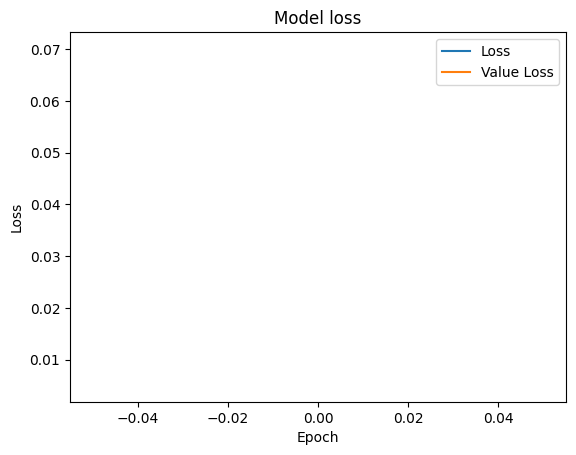

In [8]:
# Plot training & validation loss values
print(history.history.keys())
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Value Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [9]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [10]:
print(f"{train_predict.shape=}, {test_predict.shape=}, {Y_train.shape=}, {Y_test.shape=}")
print(train_predict[:2, :])

train_predict.shape=(3492, 1), test_predict.shape=(1497, 1), Y_train.shape=(3492, 6), Y_test.shape=(1497, 6)
[[0.03572115]
 [0.03777776]]


In [11]:
# Inverse transform the predictions
def update_data_to_inverse(predicted_data: np.ndarray, scaler: MinMaxScaler, target_column_index: int):
    new_dataset = np.zeros(shape=(len(predicted_data), feature_number))
    new_dataset[:,target_column_index] = predicted_data.flatten()
    return scaler.inverse_transform(new_dataset)[:, target_column_index].reshape(-1, 1)

In [12]:
train_predict = update_data_to_inverse(predicted_data=train_predict, scaler=scaler, target_column_index=target_column_index)
test_predict = update_data_to_inverse(predicted_data=test_predict, scaler=scaler, target_column_index=target_column_index)
Y_train = scaler.inverse_transform(Y_train)
Y_test = scaler.inverse_transform(Y_test)

In [19]:
print(f"{train_predict.shape=}, {test_predict.shape=}, {Y_train.shape=}, {Y_test.shape=}")
print(train_predict[4:8])
print(Y_train[4:8, target_column_index])

print(test_predict[4:8])
print(Y_test[4:8, target_column_index])

train_predict.shape=(3492, 1), test_predict.shape=(1497, 1), Y_train.shape=(3492, 6), Y_test.shape=(1497, 6)
[[7.81720414]
 [7.64919284]
 [7.73692688]
 [7.99715175]]
[0.55071402 0.54964298 0.55124998 0.56678599]
[[39.61489049]
 [39.47317703]
 [39.40325359]
 [39.3111048 ]]
[46.04000092 46.375      46.27750015 46.79499817]


In [20]:
# Calculate MSE
train_mse = mean_squared_error(Y_train[:, target_column_index].reshape(-1, 1), train_predict)
test_mse = mean_squared_error(Y_test[:, target_column_index].reshape(-1, 1), test_predict)

# Calculate R2 score
train_r2 = r2_score(Y_train[:, target_column_index].reshape(-1, 1), train_predict)
test_r2 = r2_score(Y_test[:, target_column_index].reshape(-1, 1), test_predict)

print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train R2 Score: {train_r2:.4f}, Test R2 Score: {test_r2:.4f}")

Train MSE: 39.6663, Test MSE: 1885.0787
Train R2 Score: 0.7448, Test R2 Score: 0.2535


time_step=10, X.shape=(4989, 10, 6), (len(train_predict) + time_step)=3502
test_predict.shape=(1497, 1), train_predict.shape=(3492, 1), scaled_data.shape=(5000, 6)


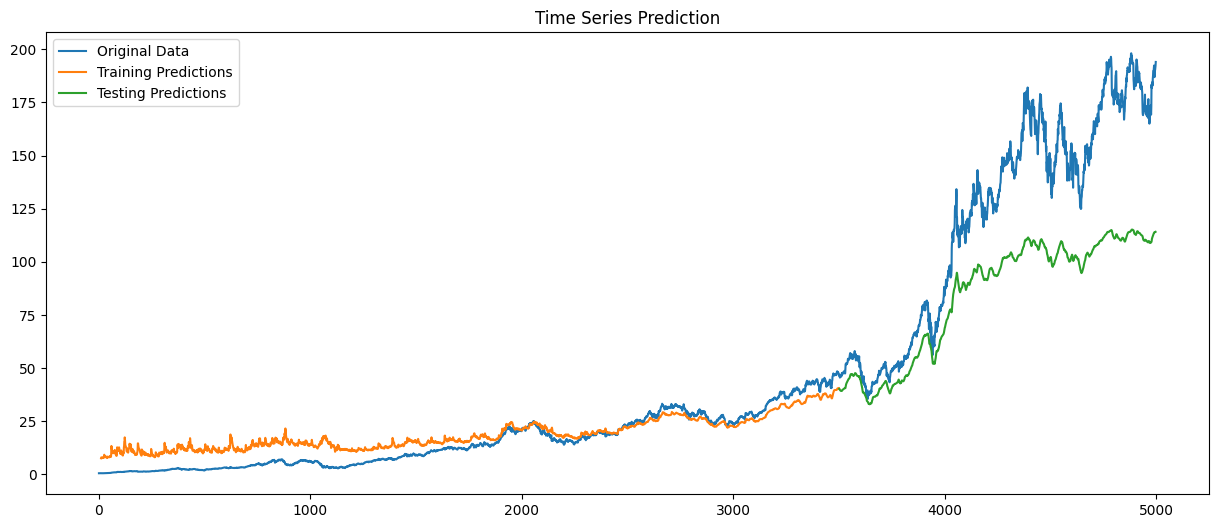

In [21]:
print(f"{time_step=}, {X.shape=}, {(len(train_predict) + time_step)=}")
print(f"{test_predict.shape=}, {train_predict.shape=}, {scaled_data.shape=}")

# Plot the predictions
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(scaled_data)[:, target_column_index], label='Original Data')
train_predict_plot = np.empty_like(scaled_data[:, target_column_index]).reshape(-1, 1)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
plt.plot(train_predict_plot, label='Training Predictions')

test_predict_plot = np.empty_like(scaled_data[:, target_column_index]).reshape(-1, 1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + time_step:len(scaled_data[:, target_column_index]) - 1, :] = test_predict
plt.plot(test_predict_plot, label='Testing Predictions')

plt.title('Time Series Prediction')
plt.legend()
plt.show()

In [ ]:
model.save('lstm_model_test.h5')

In [ ]:
# # Load the saved model
# loaded_model = load_model('lstm_model.h5')

In [ ]:
# # Assuming `X_new` and `Y_new` are new data arrays
# history_updated = loaded_model.fit(X_new, Y_new, epochs=50, batch_size=1, verbose=1)

# # Save the updated model
# loaded_model.save('updated_lstm_model.h5')